In [1]:
import pyprob #https://github.com/probprog/pyprob #!pip install pyprob
from pyprob import Model 
from pyprob.distributions import Categorical, Uniform, Normal
import numpy as np
import torch
import cv2
from pyprob import PriorInflation, InferenceEngine, InferenceNetwork
import matplotlib.pyplot as plt
import pickle
from vae import VAE, Encoder, Decoder
from pl_bolts.models.autoencoders import VAE
import pytorch_lightning as pl

Cannot import dbm.gnu: No module named '_gdbm'


C:\Users\bprys\miniconda3\lib\site-packages\pyprob\util.py:327: UserWarning: Empirical distributions on disk may perform slow because GNU DBM is not available. Please install and configure gdbm library for Python for better speed.
  warnings.warn('Empirical distributions on disk may perform slow because GNU DBM is not available. Please install and configure gdbm library for Python for better speed.')
C:\Users\bprys\miniconda3\lib\site-packages\pl_bolts\utils\warnings.py:30: UserWarning: You want to use `wandb` which is not installed yet, install it with `pip install wandb`.
  stdout_func(
C:\Users\bprys\miniconda3\lib\site-packages\pl_bolts\utils\warnings.py:30: UserWarning: You want to use `gym` which is not installed yet, install it with `pip install gym`.
  stdout_func(


In [2]:
# pip install opencv-python

In [3]:
class ImagesGen(Model):
    def __init__(self, name='ImagesModel', vae=None, opt = None):
        super().__init__(name=name)
        self.opt = opt

        self.height, self.width = 75, 75
        self.colors = [
            (0,0,255),##r
            (0,255,0),##g
            (255,0,0),##b
            (0,156,255),##o
            (128,128,128),##k
            (0,255,255)##y
            ]
        self.size = 5
        self.encoder = vae.encoder
        self.decoder = vae.decoder

    def forward(self):
        # Initialize images with 255 (white background)
        img = np.ones((self.height,self.width, 3), dtype=np.uint8)*255
        objects = []
        for color_id,color in enumerate(self.colors):  
            center = self.center_generate(objects)
            shape = pyprob.sample(Categorical(probs=[0.5,0.5]), name=f"{color_id}_shape").item()
            if shape:
                start = (center[0]-self.size, center[1]-self.size)
                end = (center[0]+self.size, center[1]+self.size)
                cv2.rectangle(img, start, end, color, -1)
                objects.append((color_id,center,'r'))
            else:
                center_ = (center[0], center[1])
                cv2.circle(img, center_, self.size, color, -1)
                objects.append((color_id,center,'c'))

        rendered_img = torch.tensor(img).float() # I had to add this for some reason --> check if it is right
        pyprob.tag(rendered_img, name="rendered_image")
        
        #Use VAE encoded represenation
        proposal_mu, proposal_logsigma = self.encoder(rendered_img.transpose(2,0).unsqueeze(0))
        proposal_sigma = torch.exp(proposal_logsigma)
        pyprob.observe(Normal(proposal_mu, proposal_sigma), name="encoded_image")
        
        # return the latent quantity of interest
        return objects

    def center_generate(self, objects):
        while True:
            pas = True
            center_x = pyprob.sample(Categorical(probs=[0] * self.size + [1/(self.height-2*self.size)]*(self.height-2*self.size)), name=f"{len(objects)}_center_x").item()
            center_y = pyprob.sample(Categorical(probs=[0] * self.size + [1/(self.height-2*self.size)]*(self.height-2*self.size)), name=f"{len(objects)}_center_y").item()
            #self.np.random.randint(0+size, img_size - size, 2)        
            center = torch.tensor([center_x, center_y])
            if len(objects) > 0:
                for name,c,shape in objects:
                    if torch.sum(((center - c) ** 2)) < ((self.size * 2) ** 2):
                        pas = False
            if pas:
                return center

In [10]:
def plot_trace(trace_image, title):
    img = np.array(trace_image.view(75,75, 3))
    img = img.astype("uint8")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.title(title)
    plt.imshow(img)
    plt.savefig("figures/example_image.pdf", bbox_inches="tight")
    plt.show()

In [5]:
size = 5
height = 75
width = 75

In [6]:
colors = [
            (0,0,255),##r
            (0,255,0),##g
            (255,0,0),##b
            (0,156,255),##o
            (128,128,128),##k
            (0,255,255)##y
            ]

In [7]:
def render_from_latents(objects):
        img = np.ones((height,width, 3), dtype=np.uint8)*255
        for obj in objects:  
            center = (obj[1][0].item(), obj[1][1].item())
            shape = obj[2]
            color = colors[obj[0]]
            if shape == "r":
                start = (center[0]-size, center[1]-size)
                end = (center[0]+size, center[1]+size)
                cv2.rectangle(img, start, end, color, -1)
            else:
                center_ = (center[0], center[1])
                cv2.circle(img, center, size, color, -1)
        return torch.tensor(img).view(-1)

In [8]:
with open("trained_vae.p", "rb") as fp:
    vae = pickle.load(fp)

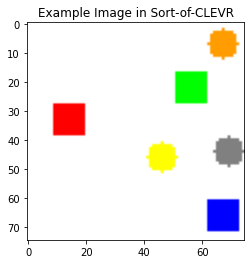

In [12]:
model = ImagesGen(vae=vae)

gt_trace = next(model._trace_generator(inference_engine=InferenceEngine.RANDOM_WALK_METROPOLIS_HASTINGS))
plot_trace(gt_trace["rendered_image"], "Example Image in Sort-of-CLEVR")

In [17]:
latent = vae.encoder(gt_trace["rendered_image"].transpose(2,0).unsqueeze(0))[0]
latent

tensor([[ 339.1036,  128.5552, -214.1156,  255.1888,   48.3177,   46.8608,
          -93.0551,   53.3484,  -50.3752,  150.8999,  112.1219,  328.5143,
          182.9744, -349.3640,   92.8182,  -15.8433,   -2.3582, -140.2192,
           74.6096,  178.5855, -168.9512, -146.2176, -289.1896, -139.6588,
          148.9116,  289.6083, -157.8490,  266.3351,  -74.5363,  172.7274,
         -143.3869, -297.2230,  358.0716,  329.4166, -262.8578, -127.0859,
          111.8020,  180.9387,  298.0641, -177.1552,   77.5449,  307.7452,
          -95.6214, -142.6584,  235.7914,  269.8233,  207.3490,   13.1387,
           97.8494, -372.7684, -207.8975, -261.0719, -404.1468,  107.9412,
         -192.1109, -193.9278, -162.3640,  -68.8033, -235.9185,  -36.7956,
         -291.4927, -242.7202,  338.5155,  295.3463]], grad_fn=<AddmmBackward>)

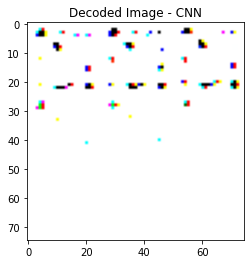

In [23]:
decoded = vae.decoder(latent).view(3, 75, 75).detach() * 255
plot_trace(decoded, "Decoded Image - CNN")

In [7]:
model.forward()

[(0, tensor([66, 66]), 'c'),
 (1, tensor([45,  5]), 'c'),
 (2, tensor([21, 58]), 'c'),
 (3, tensor([65, 27]), 'r'),
 (4, tensor([65, 13]), 'c'),
 (5, tensor([23, 12]), 'r')]

In [67]:
model = ImagesGen(vae=vae)
model.learn_inference_network(num_traces=50000,
                              observe_embeddings={'encoded_image' : {'dim' : 32}},
                              inference_network=pyprob.InferenceNetwork.LSTM)

Creating new inference network...
Observable encoded_image: reshape not specified, using shape torch.Size([1, 64]).
Observable encoded_image: using embedding dim torch.Size([32]).
Observable encoded_image: observe embedding not specified, using the default FEEDFORWARD.
Observable encoded_image: embedding depth not specified, using the default 2.
Observe embedding dimension: 32
Train. time | Epoch| Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Learn.rate| Traces/sec
New layers, address: 76__forward__center_generate__?__Categorical(len_p..., distribution: Categorical
New layers, address: 156__forward__center_generate__?__Categorical(len_..., distribution: Categorical
New layers, address: 88__forward__?__Categorical(len_probs:2)__1, distribution: Categorical
New layers, address: 76__forward__center_generate__?__Categorical(len_p..., distribution: Categorical
New layers, address: 156__forward__center_generate__?__Categorical(len_..., distribution: Categorical
New layers, ad

In [68]:
vae.encoder(gt_trace["rendered_image"])[0]

tensor([[3.0812e+02, 6.9983e+02, 4.7621e+02, 5.1733e+02, 8.5222e+01, 7.4239e+00,
         2.3220e+02, 3.8501e+02, 3.0110e+02, 4.1081e+02, 4.6325e+02, 3.7879e+02,
         4.9042e+02, 1.0744e+02, 3.4055e+02, 5.3154e+02, 4.7450e+02, 3.4160e+02,
         4.3076e+02, 5.3266e+01, 6.6525e+02, 5.1552e+02, 1.0936e+02, 4.4225e+02,
         4.4931e+02, 2.8352e+02, 5.2064e+02, 1.8290e+02, 4.7703e+02, 2.5116e+01,
         9.7586e+01, 3.5001e+02, 1.0305e+02, 1.3463e+02, 3.5277e+02, 4.3174e+02,
         5.3348e+02, 1.3295e+02, 4.2819e+01, 1.6373e+02, 1.4643e+02, 8.2197e-14,
         2.2452e+02, 8.1020e-23, 1.7816e+02, 8.5217e+02, 2.9159e+02, 1.6856e+02,
         3.1583e+02, 6.6930e+02, 4.4461e+02, 1.2188e+02, 2.6513e+02, 4.8610e+02,
         5.1912e+02, 3.6525e+02, 3.6454e+02, 7.9358e+02, 4.3139e+02, 2.0360e+02,
         3.0208e+02, 7.7898e+01, 3.4060e+02, 4.4050e+02]],
       grad_fn=<SoftplusBackward>)

In [89]:
# sample from posterior (500 samples)
posterior_results = model.posterior_results(
         num_traces=50000, # the number of samples estimating the posterior
         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING, # specify which inference engine to use
         observe={'encoded_image' : vae.encoder(gt_trace["rendered_image"])[0]} # assign values to the observed values
         )

Time spent  | Time remain.| Progress             | Trace       | ESS     | Traces/sec
0d:00:13:35 | 0d:00:00:00 | #################### | 50000/50000 |    1.00 | 61.29        


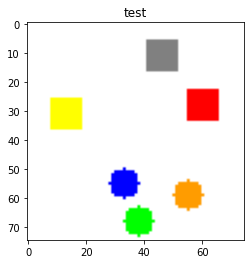

In [90]:
plot_trace(render_from_latents(posterior_results.sample()), "test")

In [91]:
plot_trace(vae.decoder(vae.encoder(gt_trace["rendered_image"])))

AttributeError: 'tuple' object has no attribute 'dim'

In [12]:
[result for result in posterior_results]

[[(0, tensor([51, 38]), 'r'),
  (1, tensor([20, 64]), 'c'),
  (2, tensor([59, 62]), 'r'),
  (3, tensor([29, 44]), 'c'),
  (4, tensor([67, 53]), 'c'),
  (5, tensor([38, 11]), 'r')],
 [(0, tensor([60, 21]), 'r'),
  (1, tensor([ 7, 38]), 'r'),
  (2, tensor([64, 48]), 'c'),
  (3, tensor([8, 3]), 'r'),
  (4, tensor([29, 16]), 'c'),
  (5, tensor([56,  7]), 'r')],
 [(0, tensor([ 3, 12]), 'r'),
  (1, tensor([66, 27]), 'r'),
  (2, tensor([ 0, 66]), 'r'),
  (3, tensor([14, 35]), 'r'),
  (4, tensor([ 3, 35]), 'c'),
  (5, tensor([55, 23]), 'r')],
 [(0, tensor([17,  9]), 'r'),
  (1, tensor([20, 42]), 'r'),
  (2, tensor([66,  5]), 'c'),
  (3, tensor([58, 22]), 'r'),
  (4, tensor([19, 53]), 'r'),
  (5, tensor([67, 34]), 'c')],
 [(0, tensor([37,  1]), 'r'),
  (1, tensor([17, 52]), 'r'),
  (2, tensor([16, 62]), 'c'),
  (3, tensor([ 7, 38]), 'r'),
  (4, tensor([21, 42]), 'c'),
  (5, tensor([12, 19]), 'r')],
 [(0, tensor([68, 51]), 'c'),
  (1, tensor([62, 36]), 'r'),
  (2, tensor([27, 65]), 'c'),
  (3, t

In [58]:
posterior_unweighted = posterior_results.unweighted()

In [67]:
posterior_results.sample()

[(0, tensor([59, 29]), 'r'),
 (1, tensor([35, 21]), 'c'),
 (2, tensor([66, 58]), 'c'),
 (3, tensor([61,  2]), 'r'),
 (4, tensor([44,  2]), 'c'),
 (5, tensor([56, 45]), 'r')]

In [96]:
rendered_posterior_sample = render_from_latents(posterior_results[1])
rendered_posterior_sample

tensor([255, 255, 255,  ..., 255, 255, 255], dtype=torch.uint8)

<ipython-input-89-86e24a039656>:7: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


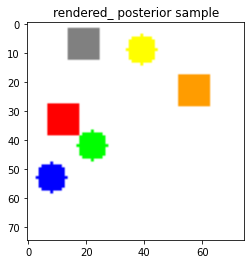

In [98]:
plot_trace(rendered_posterior_sample, "rendered_ posterior sample")

In [102]:
# guess.. instead of returning the objects, we return the VAE encoded vector. then these are continuous real numbers 
# that are weighted for importance sampling. We are calc the likelihood under Normal(mu=encoded_vector)
# then we are able to decode from the weighted samples to get the final inferred image? 